In [1]:
# python
import os
import pandas as pd
import numpy as np
import cv2
import itertools

# matplot lib
import matplotlib.pyplot as plt

# misc
from PIL import Image
from collections import defaultdict

# scipy
from scipy.stats import uniform, randint

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# xgboost
from xgboost import XGBClassifier

# skimage
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [2]:
def extract_hog_features_fast(image_path, downscale_size=(128, 128), normalize = False):
    image = imread(image_path)
    if len(image.shape) == 3:  
        image = rgb2gray(image)
    
    if normalize : 
        image = (image - image.mean()) / image.std()
        
    image_resized = resize(image, downscale_size, anti_aliasing=True)
    
    features = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      block_norm='L2-Hys',  transform_sqrt=True)
    return features


In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function plots the confusion matrix using matplotlib.
    If `normalize=True`, it will normalize the values row-wise and format them with 2 decimals.
    '''

    if normalize:
        cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
        print(np.round(cm, 2))
    else:
        print('Confusion Matrix, Without Normalization')
        print(cm)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = f'{cm[i, j]:.2f}' if normalize else f'{int(cm[i, j])}'
        plt.text(j, i, value,
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Valeur réelle')
    plt.xlabel('Valeur prédite')

In [4]:
base_path = "data"
categories = ["Normal", "COVID", "Viral Pneumonia", "Lung_Opacity"]
#categories = ["Normal", "COVID", "Viral Pneumonia"]

data = defaultdict(list)

for category in categories:
    image_dir = os.path.join(base_path, category, "images")
    mask_dir = os.path.join(base_path, category, "masks")
    
    file_names = [f.split(".")[0] for f in os.listdir(image_dir) if f.endswith(".png")]
    
    for file_name in file_names:
        image_path = os.path.join(image_dir, f"{file_name}.png")
        mask_path = os.path.join(mask_dir, f"{file_name}.png")
        
        if os.path.exists(image_path) and os.path.exists(mask_path):
            data[category].append((image_path, mask_path))
        else:
            print(f"Missing data for {file_name} in category {category}")

for category, items in data.items():
    print(f"{category}: {len(items)} images and masks loaded.")


print(data)

Normal: 10192 images and masks loaded.
COVID: 3616 images and masks loaded.
Viral Pneumonia: 1345 images and masks loaded.
Lung_Opacity: 6012 images and masks loaded.
defaultdict(<class 'list'>, {'Normal': [('data\\Normal\\images\\Normal-1.png', 'data\\Normal\\masks\\Normal-1.png'), ('data\\Normal\\images\\Normal-10.png', 'data\\Normal\\masks\\Normal-10.png'), ('data\\Normal\\images\\Normal-100.png', 'data\\Normal\\masks\\Normal-100.png'), ('data\\Normal\\images\\Normal-1000.png', 'data\\Normal\\masks\\Normal-1000.png'), ('data\\Normal\\images\\Normal-10000.png', 'data\\Normal\\masks\\Normal-10000.png'), ('data\\Normal\\images\\Normal-10001.png', 'data\\Normal\\masks\\Normal-10001.png'), ('data\\Normal\\images\\Normal-10002.png', 'data\\Normal\\masks\\Normal-10002.png'), ('data\\Normal\\images\\Normal-10003.png', 'data\\Normal\\masks\\Normal-10003.png'), ('data\\Normal\\images\\Normal-10004.png', 'data\\Normal\\masks\\Normal-10004.png'), ('data\\Normal\\images\\Normal-10005.png', 'data

In [ ]:
feature_matrix = []
labels = []

for category, items in data.items():
    label = categories.index(category) 
    print(f"{label} - {category} ")    
    for image_path, _ in items:        
        features = extract_hog_features_fast(image_path)
        feature_matrix.append(features)
        labels.append(label)

X = np.array(feature_matrix)
y = np.array(labels)

print(f"Feature matrix shape:{X.shape}")
print(f"Labels shape:{y.shape}")

0 - Normal 
1 - COVID 
2 - Viral Pneumonia 
3 - Lung_Opacity 
Feature matrix shape:(21165, 8100)
Labels shape:(21165,)


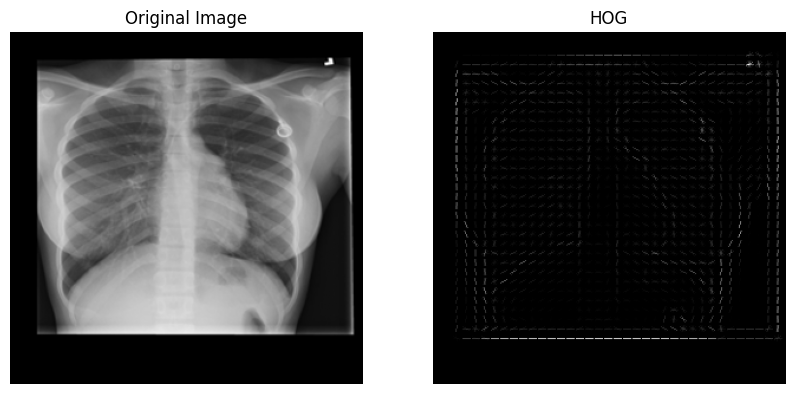

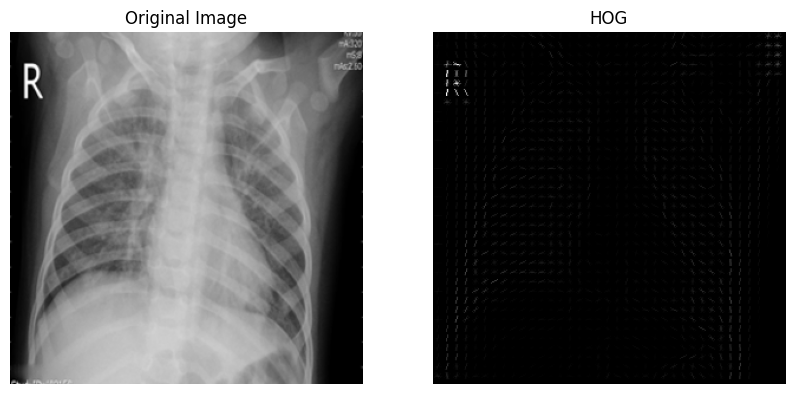

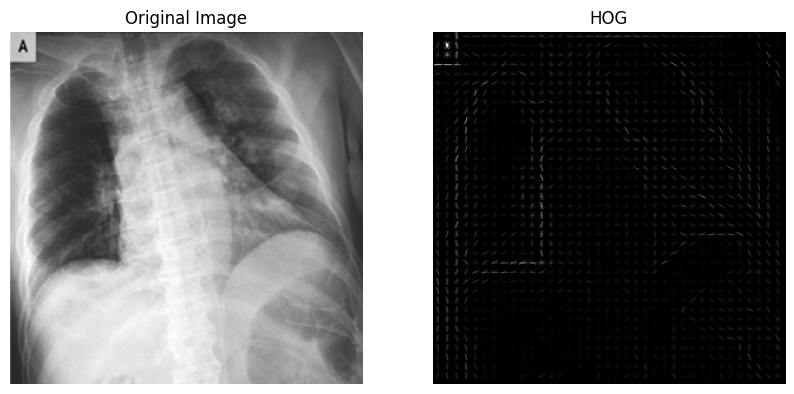

In [6]:
def visualize_hog(image_path, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    image = imread(image_path)
    
    if len(image.shape) == 3:
        image_gray = rgb2gray(image)
    else:
        image_gray = image  
    
    _, hog_image = hog(
        image_gray,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True
    )
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_gray, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG")
    plt.axis('off')
    
    plt.show()

image_path = "data/Normal/images/Normal-1.png"  
visualize_hog(image_path)
image_path = "data/Viral pneumonia/images/Viral Pneumonia-1.png"  
visualize_hog(image_path)
image_path = "data/COVID/images/COVID-2.png"  
visualize_hog(image_path)

In [7]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 16932, Testing samples: 4233


In [8]:
# Train 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict 
y_pred = knn.predict(X_test)

# Evaluate
print("KNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


KNN Classification Report:
                 precision    recall  f1-score   support

         Normal       0.75      0.93      0.83      2038
          COVID       0.82      0.48      0.60       723
Viral Pneumonia       0.96      0.84      0.90       269
   Lung_Opacity       0.80      0.70      0.74      1203

       accuracy                           0.78      4233
      macro avg       0.83      0.74      0.77      4233
   weighted avg       0.79      0.78      0.77      4233



Normalized Confusion Matrix
[[93.03  1.52  0.29  5.15]
 [37.21 47.58  0.14 15.08]
 [15.24  0.37 84.01  0.37]
 [26.35  3.49  0.25 69.91]]


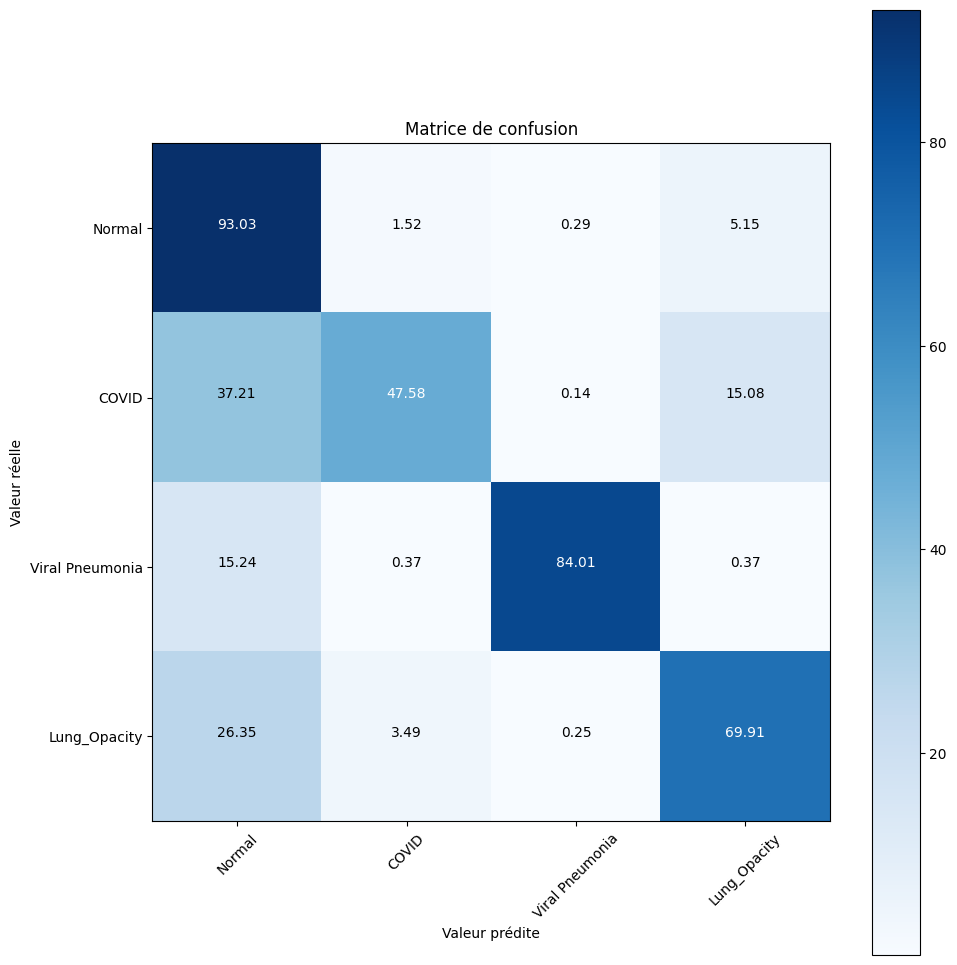

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm= cm, classes= categories, normalize= True, title = "Matrice de confusion")